#### Import libraries

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Module 1 & 2 outputs

In [36]:
macro_df = pd.read_csv('/content/drive/MyDrive/Fintech-Project/data/module1c_output.csv')
macro_df.index = pd.to_datetime(macro_df['Unnamed: 0'])
macro_df.drop(columns=['Unnamed: 0'], inplace=True)


portfolios_df = pd.read_csv('/content/drive/MyDrive/Fintech-Project/data/optimal_portfolios.csv', index_col=0)

### Define user profiles

In [37]:
user_profiles = [
    {"name": "Alex (Young Aggressive)", "age": 28, "risk_score": 0.9, "goal": "Wealth Growth", "horizon": 30},
    {"name": "Jamie (Balanced)", "age": 40, "risk_score": 0.6, "goal": "Retirement Planning", "horizon": 20},
    {"name": "Pat (Conservative)", "age": 58, "risk_score": 0.3, "goal": "Capital Preservation", "horizon": 10},
]

#### Get current macro regime (latest inversion probability)

In [38]:
latest_macro = macro_df.iloc[-1]
inversion_prob = latest_macro['Predicted_Probability']
#inversion_prob = 0.8  # simulate high recession risk
print(f"Current Inversion Risk (from Module 1 model): {inversion_prob:.2f}")

Current Inversion Risk (from Module 1 model): 0.48


#### Advisor Logic Function

In [49]:
def interpolate_weights(score):
    aggressive = np.array([0.60, 0.05, 0.35])   # SPY, AGG, GLD
    balanced   = np.array([0.35, 0.25, 0.40])
    conservative = np.array([0.05, 0.60, 0.35])

    if score >= 0.66:
        ratio = (score - 0.66) / (1.0 - 0.66)
        return (1 - ratio) * balanced + ratio * aggressive
    elif score >= 0.33:
        ratio = (score - 0.33) / (0.66 - 0.33)
        return (1 - ratio) * conservative + ratio * balanced
    else:
        return conservative

def recommend_portfolio(user, inversion_prob):
    adjusted_risk = user['risk_score'] * (1 - inversion_prob)
    weights = interpolate_weights(adjusted_risk)
    weights = np.round(weights, 2)

    advice = {
        'user': user['name'],
        'goal': user['goal'],
        'recommended_weights': dict(zip(['SPY', 'AGG', 'GLD'], weights)),
        'adjusted_risk_score': adjusted_risk,
        'original_risk_score': user['risk_score']
    }
    return advice

In [50]:
# Run advisor for all users
recommendations = [recommend_portfolio(user, inversion_prob) for user in user_profiles]

In [51]:
# Show results
for rec in recommendations:
    print(f"\n📌 Recommendation for {rec['user']}")
    print(f"  Goal: {rec['goal']}")
    print(f"  Adjusted Risk Score: {rec['adjusted_risk_score']:.2f} (from {rec['original_risk_score']:.2f})")
    print("  Recommended Allocation:")
    for asset, weight in rec['recommended_weights'].items():
        print(f"    {asset}: {weight*100:.1f}%")


📌 Recommendation for Alex (Young Aggressive)
  Goal: Wealth Growth
  Adjusted Risk Score: 0.46 (from 0.90)
  Recommended Allocation:
    SPY: 17.0%
    AGG: 46.0%
    GLD: 37.0%

📌 Recommendation for Jamie (Balanced)
  Goal: Retirement Planning
  Adjusted Risk Score: 0.31 (from 0.60)
  Recommended Allocation:
    SPY: 5.0%
    AGG: 60.0%
    GLD: 35.0%

📌 Recommendation for Pat (Conservative)
  Goal: Capital Preservation
  Adjusted Risk Score: 0.15 (from 0.30)
  Recommended Allocation:
    SPY: 5.0%
    AGG: 60.0%
    GLD: 35.0%


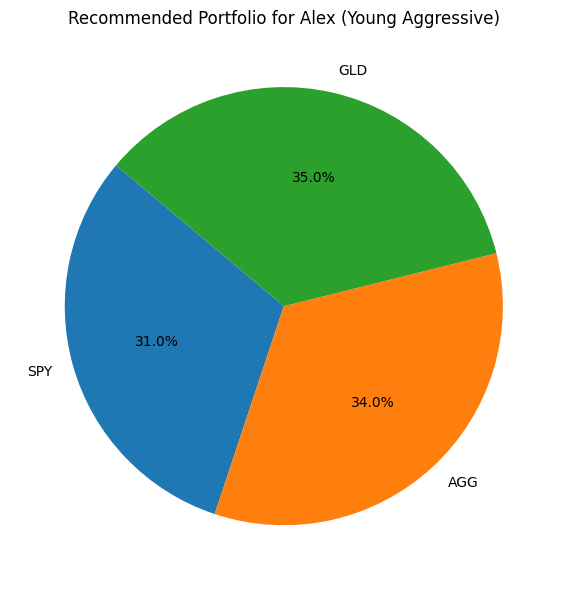

In [48]:
# Visualize for one user
selected = recommendations[0]  # Pick Alex
labels = list(selected['recommended_weights'].keys())
sizes = list(selected['recommended_weights'].values())

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title(f"Recommended Portfolio for {selected['user']}")
plt.tight_layout()
plt.show()


In [43]:
# Save results (optional)
pd.DataFrame(recommendations).to_csv('/content/drive/MyDrive/Fintech-Project/data/robo_recommendations.csv', index=False)

In [44]:
import json

# Flatten recommended_weights dict for saving
for rec in recommendations:
    for asset, weight in rec['recommended_weights'].items():
        rec[asset] = weight
    del rec['recommended_weights']

pd.DataFrame(recommendations).to_csv('/content/drive/MyDrive/Fintech-Project/data/module3_robo_output.csv', index=False)